#  Teeth Classification

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from collections import Counter
import time
from PIL import Image
import cv2

# Loading data


dict_values([480, 450, 360, 540, 324, 540, 393])
dict_values([160, 149, 120, 180, 108, 180, 131])
dict_values([160, 149, 120, 180, 108, 180, 131])


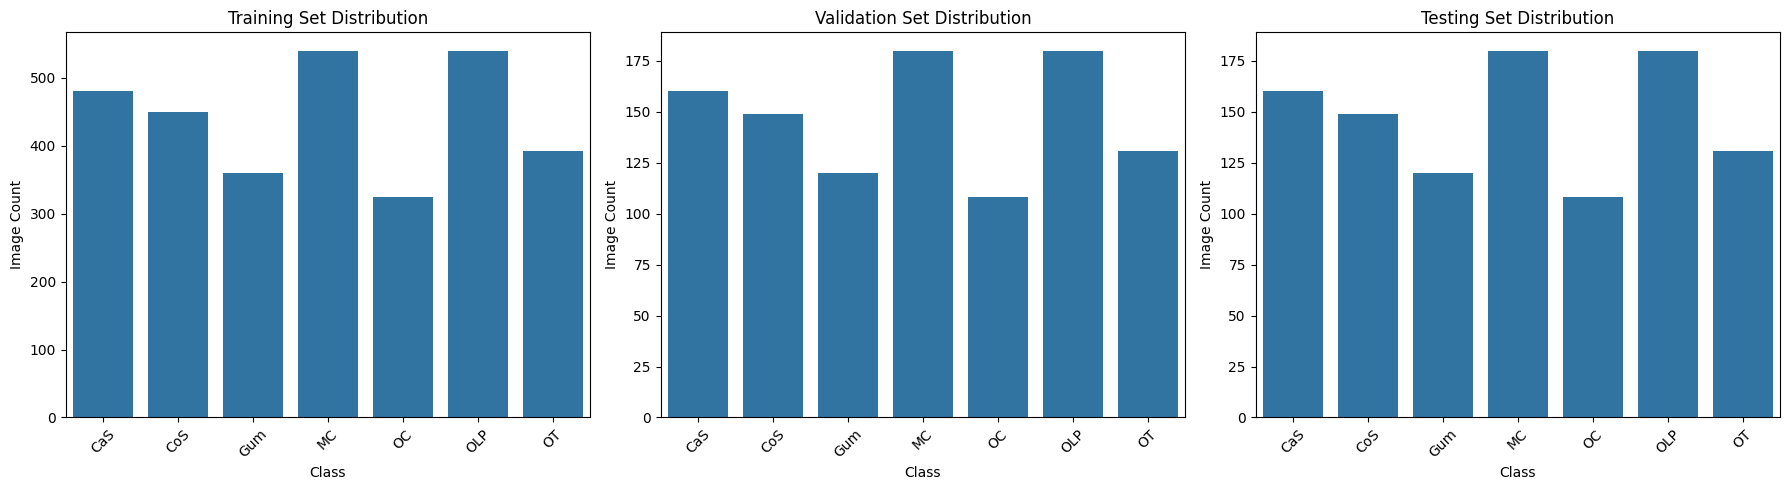

In [16]:
img_size = (224, 224)
batch_size = 16

data_dir = os.path.join(os.path.dirname(os.getcwd()), 'Teeth_Dataset')
train_dir = os.path.join(data_dir, 'Training')
valid_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'Testing')


splits = ['Training', 'Validation', 'Testing']

all_class_counts = {}

for split in splits:
    split_path = os.path.join(data_dir, split)
    class_counts = {}
    
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            img_files = [
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ]
            class_counts[class_name] = len(img_files)
    
    all_class_counts[split] = class_counts
    print(class_counts.values())

plt.figure(figsize=(18, 5))

for i, split in enumerate(splits):
    plt.subplot(1, 3, i + 1)
    counts = all_class_counts[split]
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(f"{split} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Image Count")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=15,
                                    zoom_range=0.1,
                                    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=img_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


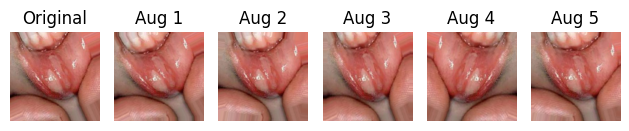

In [18]:

img_path = r"..\Teeth_Dataset\Training\CaS\a_79_0_707.jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Show original
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

for i, batch in enumerate(train_datagen.flow(img_array, batch_size=1)):
    plt.subplot(1, 6, i + 2)
    plt.imshow(batch[0])
    plt.title(f"Aug {i+1}")
    plt.axis('off')
    if i == 4:
        break
plt.tight_layout()
plt.show()

In [19]:
base_model = InceptionV3(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dense(7, activation='softmax')  
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_284 (Ba  (None, 512)              2048      
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [20]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Optional: show device names
tf.config.list_physical_devices()


TensorFlow version: 2.10.0
Num GPUs Available: 1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        epochs=50,  
        validation_data=valid_generator,
        callbacks=[early_stop]
    )


Epoch 1/50
193/193 [==============================] - 49s 225ms/step - loss: 1.1559 - accuracy: 0.5944 - val_loss: 1.3612 - val_accuracy: 0.5710
Epoch 2/50
193/193 [==============================] - 40s 207ms/step - loss: 0.7009 - accuracy: 0.7480 - val_loss: 0.6547 - val_accuracy: 0.7510
Epoch 3/50
193/193 [==============================] - 42s 215ms/step - loss: 0.5551 - accuracy: 0.8108 - val_loss: 0.6361 - val_accuracy: 0.7636
Epoch 4/50
193/193 [==============================] - 38s 196ms/step - loss: 0.4384 - accuracy: 0.8471 - val_loss: 0.4369 - val_accuracy: 0.8453
Epoch 5/50
193/193 [==============================] - 39s 200ms/step - loss: 0.4135 - accuracy: 0.8526 - val_loss: 0.4889 - val_accuracy: 0.8317
Epoch 6/50
193/193 [==============================] - 40s 205ms/step - loss: 0.3412 - accuracy: 0.8860 - val_loss: 0.4659 - val_accuracy: 0.8395
Epoch 7/50
193/193 [==============================] - 39s 200ms/step - loss: 0.3171 - accuracy: 0.8941 - val_loss: 0.4247 - val_ac

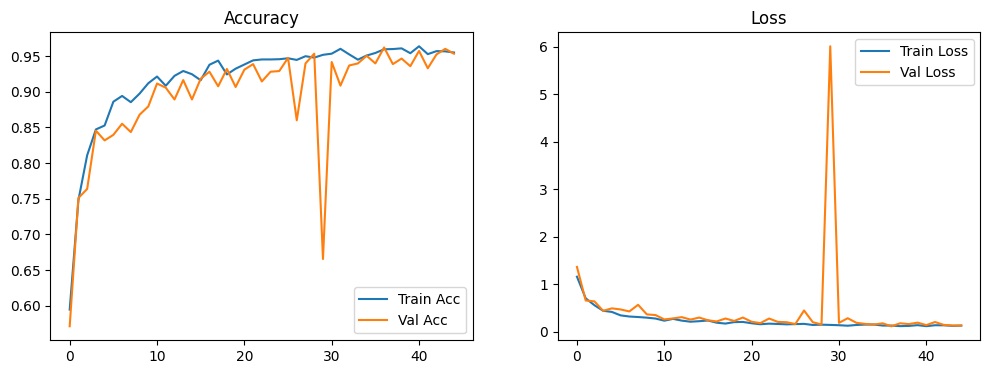

In [22]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


65/65 [==============================] - 5s 57ms/step
Classification Report:

              precision    recall  f1-score   support

         CaS       0.98      0.94      0.96       160
         CoS       1.00      1.00      1.00       149
         Gum       0.94      0.97      0.96       120
          MC       0.97      0.95      0.96       180
          OC       0.89      0.98      0.93       108
         OLP       0.95      0.90      0.93       180
          OT       0.96      0.99      0.97       131

    accuracy                           0.96      1028
   macro avg       0.96      0.96      0.96      1028
weighted avg       0.96      0.96      0.96      1028

Confusion Matrix:


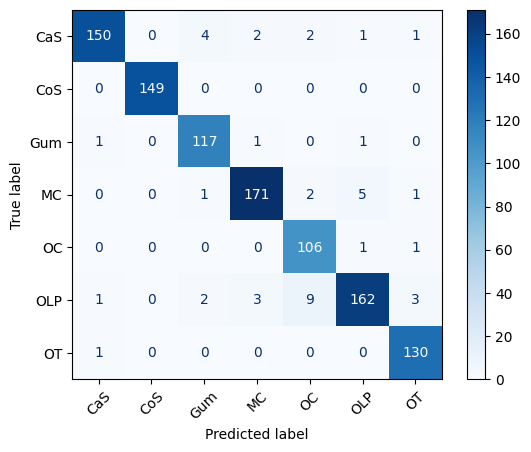

In [23]:
pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

y_true = test_generator.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=counts.keys()))

cm = confusion_matrix(y_true, y_pred)

# Display as text
print("Confusion Matrix:")


# Display as a color-coded heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=counts.keys())
disp.plot(cmap='Blues', xticks_rotation=45)

In [25]:
model.save('teeth_classification_model.h5')